In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(words[:8])
#print(type(words)) # splitlines returns a list
print(max(len(w) for w in words))

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
15


In [3]:
# building the vocanulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [89]:
# building the dataset
block_size = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [60]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '------>', itos[y.item()])

........ ------> y
.......y ------> u
......yu ------> h
.....yuh ------> e
....yuhe ------> n
...yuhen ------> g
..yuheng ------> .
........ ------> d
.......d ------> i
......di ------> o
.....dio ------> n
....dion ------> d
...diond ------> r
..diondr ------> e
.diondre ------> .
........ ------> x
.......x ------> a
......xa ------> v
.....xav ------> i
....xavi ------> e


In [138]:
# training a deeper n/w

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True): # fan_in = input_features, similarly out
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1): # dim = num of features of input
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training: 
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean (instead of passing the 0th dimension alone now passed a tuple to get mean over 0th and 1st dimension as 3 dimensional tensor now)
            xvar = x.var(dim, keepdim=True)
        else: # while giving the single input while testing(not training)
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    

class FlattenConsecutive:
    
    def __init__(self, n): # n would signify how many characters to send to the next layer(2 in our case)
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze() # squeeze the first dimension ie like before will give 2 dimensional tensor
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    

class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get the params of all the layers and stretch them into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [139]:
torch.manual_seed(42);

In [149]:
n_embed = 24 # the dimension of the character embedding vectors
n_hidden = 128
#C = torch.randn((vocab_size, n_embed))

# list of layers required in MLP
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),
])


# batch norm layer only taking mean over the 0th dimension, but tensors changed from 2 to 3 dimensions, so need to fix that.

with torch.no_grad():
    # last layer: make less confident (as seen above)
    # since last layer has been updated to batchnorm1d, wont be changing the last layers's weight instead the factor gamma which multiplicatively interacts with the output of that normalization
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3 # since using tanh
            
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total parameters
for p in parameters:
    p.requires_grad = True

76579


In [130]:
# # running the after block once before running this block to pass the input to model to work on, previously just initialized the layers

# for layer in model.layers:
#     print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


### example how to make a wavenet like architecture

In [129]:
# ix = torch.randint(0, Xtr.shape[0], (4,)) # taking 4 as a batch size here each of 8 characters and each character of 10 dim
# Xb, Yb = Xtr[ix], Ytr[ix]
# logits = model(Xb)
# print(Xb.shape)
# Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  1,  2, 18,  9],
        [ 0,  0,  0, 22,  9,  3, 20, 15],
        [ 0,  0,  1, 14,  7,  5, 12,  5],
        [19, 15,  3,  8,  9, 11,  1,  9]])

In [69]:
# model.layers[0].out.shape # model a object of sequential, has layers, each layer stores it's output in out which is accessed.
# # embedding layer

torch.Size([4, 8, 10])

In [70]:
# model.layers[1].out.shape # flatten (all 8 characters into a single row) and columns being the batch size

torch.Size([4, 80])

In [71]:
# model.layers[2].out.shape # linear multiplied with (80, 200) weight matrix

torch.Size([4, 200])

In [72]:
# (torch.randn(4,4,20) @ torch.randn(20, 200) + torch.randn(200)).shape # here only last dimension should match, and @ can be used
# # so this feature of '@' can be used to implement wavenet architecture where all the contexts are not fed together to next
# # layer, instead 2 charcters are fed here
# # so need to change the flatten layer that changes (4, 8, 10) to (4, 4, 20) and then multiplied with weight matrix.
# # basically flatten layer creates this mini batch of 2 charcaters inside a batch for us.
# # so does change the linear layer as well, the dim of weight matrix, how many numbers it should expect here 20.

# # block_size = 8, n_embed = 10 ( 8 characters of 10 dimension each to predict the next character)
# # need to feed only 2 character each so 2x10 and total 4 so 
# (1,2), (3,4), (5,6), (7,8) # process all of them in parallel

torch.Size([4, 4, 200])

In [80]:
# e = torch.randn(4, 8, 10)
# explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
# explicit.shape
# explicit
# # taking all the even characters and the odd characters and placing them right next to each other
# # (0,1),(2,3),(4,5),(6,7)

torch.Size([4, 4, 20])

In [81]:
# # could also be done this way using view only
# (e.view(4,4,20) == explicit).all()

tensor(True)

### end of the example

In [150]:
max_steps =  50000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
#     x = Xb
# #     emb = C[Xb]
# #     x = emb.view(emb.shape[0], -1)
#     for layer in layers:
#         x = layer(x) # Linear was already initialized above now calling only to get Y of that layer and stored in x
#     loss = F.cross_entropy(x, Yb) # comparing final logits and Yb

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  50000: 3.5936
  10000/  50000: 2.0988
  20000/  50000: 2.3559
  30000/  50000: 1.8906
  40000/  50000: 1.9149


In [134]:
#plt.plot(lossi)

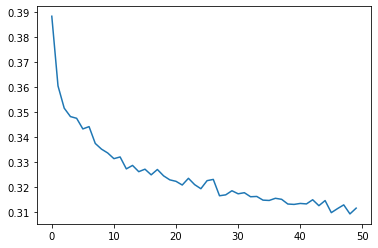

In [144]:
# plotting a much better loss curve
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [151]:
# evaluate the loss
@torch.no_grad() # this decorator disabless gradient tarcking
def split_loss(split):
    x, y = {
        'train' : {Xtr, Ytr},
        'val' : {Xdev, Ydev},
        'test' : {Xte, Yte},
    }[split]
    
#     emb = C[x] #(N, block_size, n_embd(10))
#     x = emb.view(emb.shape[0], -1)
#     for layer in layers:
#         x = layer(x)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9709885120391846
val 2.0740771293640137


In [162]:
# put layers into eval mode(needed especially for batchnorm layer(due to mean and std))
for layer in model.layers:
    layer.training = False

In [164]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # contains index of each alpha initially '...'
    while True:
        logits = model(torch.tensor([context]))
#         emb = C[torch.tensor([context])] #(1, block_size, d)
#         x = emb.view(emb.shape[0], -1)
#         for layer in layers:
#             x = layer(x)
#         logits = x # gives the count
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

emadelin.
phar.
ketta.
lua.
inar.
fenne.
xaviana.
danika.
zharee.
addin.
mazalyna.
makinley.
dreyra.
kola.
malay.
karrin.
marie.
zatalia.
kevan.
bogan.


In [207]:
# sample from the model

# asking model to predict names starting from 'sun'
for _ in range(20):
    
    out = [19, 21, 14]
    context = [0] * block_size # contains index of each alpha initially '...'
    context = context[1:] + [stoi['s']]
    context = context[1:] + [stoi['u']]
    context = context[1:] + [stoi['n']]
    while True:
        logits = model(torch.tensor([context]))
#         emb = C[torch.tensor([context])] #(1, block_size, d)
#         x = emb.view(emb.shape[0], -1)
#         for layer in layers:
#             x = layer(x)
#         logits = x # gives the count
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

suncyn.
sunae.
suno.
sunceker.
suncen.
suna.
sunnie.
sunaira.
sunta.
sunneenar.
sunce.
sundrar.
sunnie.
sunsiyah.
sunaleigh.
suncema.
sun.
sunica.
sunana.
sundin.


In [206]:
stoi['s'], stoi['u'], stoi['n']

(19, 21, 14)